In [4]:
import pandas as pd
import numpy as np
import random
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt

# Question 1

# a: No Covariates

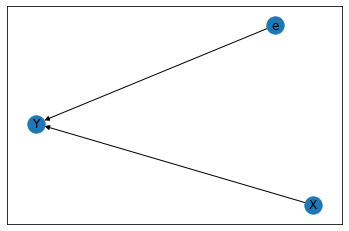

In [5]:
#DAG
import networkx as nx
DAG=nx.DiGraph()
DAG.add_edges_from([("X","Y"),("e","Y")])
plt.tight_layout()
nx.draw_networkx(DAG, arrows=True)

In [25]:
#Real life example:
#Randomly assign a treatment drug to some patients, other patients get a placebo. An example may be a weight loss drug.
#X is the treatment (ie drug or placebo assigment). Y reflects the outcome (ie weight of patients after assignment).
#(Assume e is the error term) 

In [6]:
class MC_Simulator():
    
    #Initialize
    def __init__(self,n_rep):
        self.n_rep = n_rep
        #n_rep= number of MC (monte carlo) replications 
    
    #Data generating process
    def simulate_data(self, a, b,n,sigma):
        #Let a= intercept, b=slope, n=sample size, sigma=error variance
        #Randomly draw X from a uniform distribution and e from a normal distribution
        X = np.random.uniform(0,1,n)
        e = np.random.normal(0,10,n)
        Y = a+b*X+e
        return (Y,X)
    
    #Define the OLS model and get parameters
    def estimate_ols_params(self,Y,X):
        mod = sm.OLS(Y,sm.add_constant(X))
        res = mod.fit()
        return res.params
    
    #Pass generated data through the OLS model above to get estimates for a and b
    def run_mc_simulation(self,a,b,n,sigma):
        a_estimates = []
        b_estimates = []
        for rep in range(self.n_rep):
            Y,X = self.simulate_data(a,b,n,sigma)
            #store estimates in a list, append with every iteration
            a_hat,b_hat = self.estimate_ols_params(Y,X)
            a_estimates = a_estimates + [a_hat]
            b_estimates = b_estimates + [b_hat]
        return a_estimates, b_estimates
    
    #Summarize a and b estimates with mean
    def summarize_mc_simulation(self,a,b,n,sigma):
        a_estimates, b_estimates = self.run_mc_simulation(a,b,n,sigma)
        print(f'Mean intercept intercept={np.mean(a_estimates):.3f} \n')
        print(f'Mean intercept slope={np.mean(b_estimates):.3f} \n')
    
    #Plot parameter estimates
    def plot_parameter_estimates(self,a,b,n,sigma,alpha):
        a_estimates, b_estimates = self.run_mc_simulation(a,b,n,sigma)
        fig = plt.figure()
        plt.hist(a_estimates, label = 'intercept', alpha = alpha)
        plt.hist(b_estimates, label = 'slope', alpha = alpha)
        plt.legend()

Mean intercept intercept=1.670 

Mean intercept slope=-0.093 



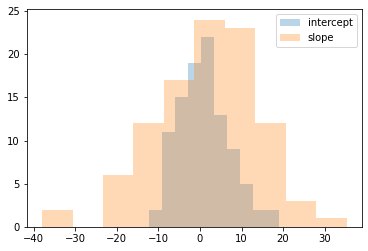

In [7]:
#MC simulation for 100 replications
mcSim = MC_Simulator(100)
mcSim.summarize_mc_simulation(1,2,10,0.1)
mcSim.plot_parameter_estimates(1,2,10,0.1,.3)

Mean intercept intercept=1.042 

Mean intercept slope=1.916 



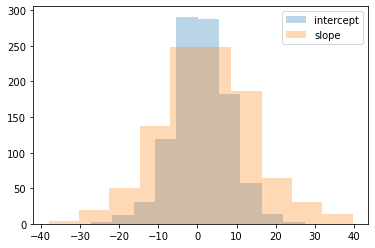

In [8]:
#MC simulation for 1000 replications
mcSim = MC_Simulator(1000)
mcSim.summarize_mc_simulation(1,2,10,0.1)
mcSim.plot_parameter_estimates(1,2,10,0.1,.3)

In [9]:
#Calculate bias, rmse, size of treatment effect estimate
N=[100,1000]
a=1
b=2
n=10
for N in [100,1000]:
    slope_estimates = []
    sum_bias= 0
    for mc_replication in range(N):
        X = np.random.uniform(0,1,n)
        e = np.random.normal(0,10,n)
        Y = a+b*X+e
        mod = sm.OLS(Y,sm.add_constant(X))
        res = mod.fit()
        slope_estimates = slope_estimates + [res.params[1]]
        bias = b - res.params[1]
        sum_bias += bias
    rmse = np.sqrt(np.mean(sum_bias**2))
    size = res.params[1]
    print(f'N={N}: bias={bias}, RMSE={rmse}, Size of Treatment Effect={size}')

N=100: bias=-9.637989603871016, RMSE=105.52793344066386, Size of Treatment Effect=11.637989603871016
N=1000: bias=4.670662781691044, RMSE=1113.7311743039002, Size of Treatment Effect=-2.6706627816910444


# b: Control for covariates

In [10]:
#Add two covariates to the equation: height and sex. 
#Height is in cm. 
#Sex=0 for females, sex=1 for males. 

class MC_Simulator():
    
    #Initialize
    def __init__(self,n_rep):
        self.n_rep = n_rep
        #n_rep= number of MC (monte carlo) replications 
    
    #Data generating process
    def simulate_data(self, a, b,n,c,d,sigma):
        #Let a= intercept, b=slope, n=sample size, c=coefficient on height, d= coefficient on sex,sigma=error variance
        #Randomly draw X from a uniform distribution and e from a normal distribution
        X = np.random.uniform(0,1,n)
        e = np.random.normal(0,10,n)
        #Randomly draw height from a normal distribution 
        height=np.random.normal(176,6,n)
        #Randomly draw sex from a uniform distribution 
        sex=np.random.uniform(0,1,n)
        Y = a+b*X+c*height+d*sex+e
        xi=np.array([X,height,sex])
        Y=np.array([Y])
        return (Y,xi)
    
    #Define the OLS model and get parameters
    def estimate_ols_params(self,Y,xi):
        #xi=np.delete(xi,0,1)
        Y=np.transpose(Y,(1,0))
        xi=np.transpose(xi,(1,0))
        #print(xi.shape)
        #print(Y.shape)
        mod = sm.OLS(Y,sm.add_constant(xi))
        res = mod.fit()
        #print(res.params)
        #print(res.summary())
        return res.params
    
    #Pass generated data through the OLS model above to get estimates for a and b
    def run_mc_simulation(self,a,b,n,c,d,sigma):
        a_estimates = []
        b_estimates = []
        c_estimates = []
        d_estimates = []
        for rep in range(self.n_rep):
            Y,xi = self.simulate_data(a,b,n,c,d,sigma)
            #store estimates in a list, append with every iteration
            a_hat,b_hat,c_hat,d_hat = self.estimate_ols_params(Y,xi)
            a_estimates = a_estimates + [a_hat]
            b_estimates = b_estimates + [b_hat]
            c_estimates = c_estimates + [c_hat]
            d_estimates = d_estimates + [d_hat]
        return a_estimates, b_estimates, c_estimates, d_estimates
    
    #Summarize a,b,c,d estimates with mean
    def summarize_mc_simulation(self,a,b,n,c,d,sigma):
        a_estimates, b_estimates, c_estimates, d_estimates = self.run_mc_simulation(a,b,n,c,d,sigma)
        print(f'Mean intercept a={np.mean(a_estimates):.3f} \n')
        print(f'Mean slope treatment b={np.mean(b_estimates):.3f} \n')
        print(f'Mean slope height c={np.mean(c_estimates):.3f} \n')
        print(f'Mean slope sex d={np.mean(d_estimates):.3f} \n')
    
    #Plot parameter estimates
    def plot_parameter_estimates(self,a,b,n,c,d,sigma,alpha):
        a_estimates, b_estimates, c_estimates, d_estimates = self.run_mc_simulation(a,b,n,c,d,sigma)
        fig = plt.figure()
        plt.hist(a_estimates, label = 'intercept', alpha = alpha)
        plt.hist(b_estimates, label = 'b', alpha = alpha)
        plt.hist(c_estimates, label = 'c', alpha = alpha)
        plt.hist(d_estimates, label = 'd', alpha = alpha)
        plt.legend()

Mean intercept a=-9.553 

Mean slope treatment b=4.059 

Mean slope height c=0.251 

Mean slope sex d=2.753 



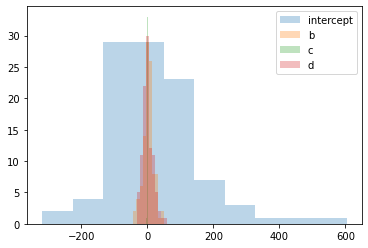

In [11]:
#MC simulation for 100 replications
mcSim = MC_Simulator(100)
mcSim.summarize_mc_simulation(1,2,10,0.2,0.3,0.1)
mcSim.plot_parameter_estimates(1,2,10,0.2,0.3,0.1,.3)

Mean intercept a=-2.198 

Mean slope treatment b=1.737 

Mean slope height c=0.219 

Mean slope sex d=0.176 



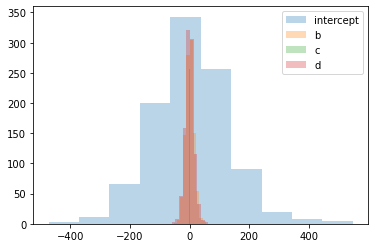

In [12]:
#MC simulation for 1000 replications
mcSim = MC_Simulator(1000)
mcSim.summarize_mc_simulation(1,2,10,0.2,0.3,0.1)
mcSim.plot_parameter_estimates(1,2,10,0.2,0.3,0.1,.3)

In [13]:
#Calculate bias, rmse, size of treatment effect estimate
N=[100,1000]
a=1
b=2
c=0.2
d=0.3
n=10
for N in [100,1000]:
    slope_estimates = []
    sum_bias= 0
    for mc_replication in range(N):
        X = np.random.uniform(0,1,n)
        e = np.random.normal(0,10,n)
        height=np.random.normal(176,6,n)
        sex=np.random.uniform(0,1,n)
        Y = a+b*X+c*height+d*sex+e
        xi=np.array([X,height,sex])
        Y=np.array([Y])
        Y=np.transpose(Y,(1,0))
        xi=np.transpose(xi,(1,0))
        mod = sm.OLS(Y,sm.add_constant(xi))
        res = mod.fit()
        slope_estimates = slope_estimates + [res.params[1]]
        bias = b - res.params[1]
        sum_bias += bias
    rmse = np.sqrt(np.mean(sum_bias**2))
    size = res.params[1]
    print(f'N={N}: bias={bias}, RMSE={rmse}, Size of Treatment Effect={size}')

N=100: bias=0.4698035240425362, RMSE=76.16160032449736, Size of Treatment Effect=1.5301964759574638
N=1000: bias=-16.19113448866195, RMSE=4.425670263904582, Size of Treatment Effect=18.19113448866195


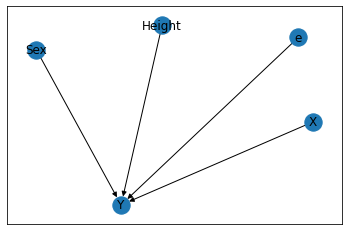

In [14]:
#DAG
import networkx as nx
DAG=nx.DiGraph()
DAG.add_edges_from([("X","Y"),("e","Y"),("Sex","Y"),("Height","Y")])
plt.tight_layout()
nx.draw_networkx(DAG, arrows=True)

# Question 2

# Part a: fail to control for confounder

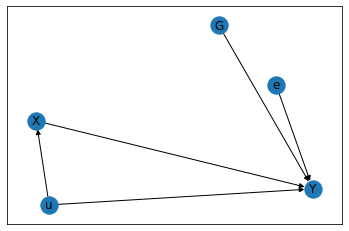

In [198]:
#Create a DAG
import networkx as nx
DAG=nx.DiGraph()
DAG.add_edges_from([("X","Y"),("G","Y"),("u","Y"),("u","X"),("e","Y")])
plt.tight_layout()
nx.draw_networkx(DAG, arrows=True)

In [72]:
#Real life example: Let Y be earnings, X be years of schooling, G be gender, e be the error term, and U be the confounder.
#The confounder u in this situation could be ability.
#This is because ability influences both Y and X. Higher levels of ability may lead to higher education and wages.

In [15]:
from linearmodels.iv import IV2SLS

#Let confounder be u. The confounder is correlated with X

class MC_Simulator():
    
    #Initialize
    def __init__(self,n_rep):
        self.n_rep = n_rep
        #n_rep= number of MC (monte carlo) replications 
    
    #Data generating process
    def simulate_data(self, a, b,c,n,sigma):
        #Let a= intercept, b=slope, n=sample size, sigma=error variance
        #Randomly draw u from a uniform distribution and e from a normal distribution
        u = np.random.uniform(0,1,n)
        e = np.random.normal(0,10,n)
        #X is correlated with u, assume correlation of 0.2
        X=0.2*u
        G = np.random.uniform(0,1,n)
        Y = a+b*X+c*G+e
        xi=np.array([X,G])
        Y=np.array([Y])
        return (Y,xi)
    
    #Define the OLS model and get parameters
    def estimate_ols_params(self,Y,xi):
        Y=np.transpose(Y,(1,0))
        xi=np.transpose(xi,(1,0))
        mod = sm.OLS(Y,sm.add_constant(xi))
        res = mod.fit()
        return res.params
    
    #Pass generated data through the OLS model above to get estimates for a and b
    def run_mc_simulation(self,a,b,c,n,sigma):
        a_estimates = []
        b_estimates = []
        c_estimates = []
        for rep in range(self.n_rep):
            Y,xi = self.simulate_data(a,b,c,n,sigma)
            #store estimates in a list, append with every iteration
            a_hat,b_hat,c_hat = self.estimate_ols_params(Y,xi)
            a_estimates = a_estimates + [a_hat]
            b_estimates = b_estimates + [b_hat]
            c_estimates = c_estimates + [c_hat]
        return a_estimates, b_estimates, c_estimates
    
    #Summarize a and b estimates with mean
    def summarize_mc_simulation(self,a,b,c,n,sigma):
        a_estimates, b_estimates, c_estimates = self.run_mc_simulation(a,b,c,n,sigma)
        print(f'Mean intercept intercept={np.mean(a_estimates):.3f} \n')
        print(f'Mean intercept slope={np.mean(b_estimates):.3f} \n')
        print(f'Mean intercept slope c={np.mean(c_estimates):.3f} \n')
    
    #Plot parameter estimates
    def plot_parameter_estimates(self,a,b,c,n,sigma,alpha):
        a_estimates, b_estimates, c_estimates = self.run_mc_simulation(a,b,c,n,sigma)
        fig = plt.figure()
        plt.hist(a_estimates, label = 'intercept', alpha = alpha)
        plt.hist(b_estimates, label = 'slope', alpha = alpha)
        plt.hist(c_estimates, label = 'c slope', alpha = alpha)
        plt.legend()

Mean intercept intercept=2.408 

Mean intercept slope=-6.204 

Mean intercept slope c=-0.501 



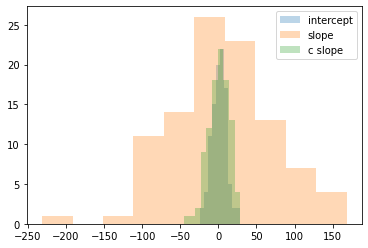

In [16]:
#MC simulation for 100 replications
mcSim = MC_Simulator(100)
mcSim.summarize_mc_simulation(1,2,0.3,10,0.1)
mcSim.plot_parameter_estimates(1,2,0.3,10,0.1,.3)

Mean intercept intercept=0.634 

Mean intercept slope=4.828 

Mean intercept slope c=0.400 



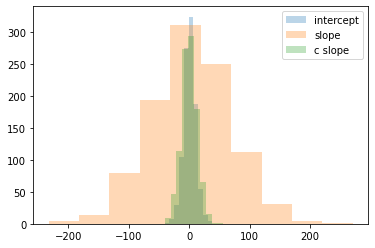

In [17]:
#MC simulation for 1000 replications
mcSim = MC_Simulator(1000)
mcSim.summarize_mc_simulation(1,2,0.3,10,0.1)
mcSim.plot_parameter_estimates(1,2,0.3,10,0.1,.3)

In [18]:
#Calculate bias, rmse, size of treatment effect estimate
N=[100,1000]
a=1
b=2
c=0.3
n=10
for N in [100,1000]:
    slope_estimates = []
    sum_bias= 0
    for mc_replication in range(N):
        u = np.random.uniform(0,1,n)
        e = np.random.normal(0,10,n)
        #X is correlated with u, assume correlation of 0.2
        X=0.2*u
        G = np.random.uniform(0,1,n)
        Y = a+b*X+c*G+e
        xi=np.array([X,G])
        Y=np.array([Y])
        Y=np.transpose(Y,(1,0))
        xi=np.transpose(xi,(1,0))
        mod = sm.OLS(Y,sm.add_constant(xi))
        res = mod.fit()
        slope_estimates = slope_estimates + [res.params[1]]
        bias = b - res.params[1]
        sum_bias += bias
    rmse = np.sqrt(np.mean(sum_bias**2))
    size = res.params[1]
    print(f'N={N}: bias={bias}, RMSE={rmse}, Size of Treatment Effect={size}')

N=100: bias=54.8103590135932, RMSE=783.3424489949725, Size of Treatment Effect=-52.8103590135932
N=1000: bias=12.249020576108236, RMSE=2508.8595245484207, Size of Treatment Effect=-10.249020576108236


# Part b: control for confounder

In [19]:
#Part b: control for confounder u by adding instrumental variable Z

from linearmodels.iv import IV2SLS

class MC_Simulator():
    
    #Initialize
    def __init__(self,n_rep):
        self.n_rep = n_rep
        #n_rep= number of MC (monte carlo) replications 
    
    #Data generating process
    def simulate_data(self, a, b,c,n,sigma):
        #Let a= intercept, b=slope, n=sample size, sigma=error variance
        #Randomly draw u from a uniform distribution and e from a normal distribution
        u = np.random.uniform(0,1,n)
        e = np.random.normal(0,10,n)
        #X is correlated with u, assume correlation of 0.2
        X=0.2*u
        G = np.random.uniform(0,1,n)
        Y = a+b*X+c*G+e
        return (Y,X,G)
    
    #Define the OLS model and get parameters
    def estimate_ols_params(self,Y,X,G):
        Z=np.random.uniform(0,1,n)
        #formula = 'Y ~ 1 + [X~Z]'
        G=sm.add_constant(G)
        mod = IV2SLS(dependent=Y, exog=G, endog=X, instruments=Z)
        res = mod.fit()
        return res.params
    
    #Pass generated data through the OLS model above to get estimates for a and b
    def run_mc_simulation(self,a,b,c,n,sigma):
        a_estimates = []
        b_estimates = []
        c_estimates = []
        for rep in range(self.n_rep):
            Y,X,G = self.simulate_data(a,b,c,n,sigma)
            #store estimates in a list, append with every iteration
            a_hat,b_hat,c_hat = self.estimate_ols_params(Y,X,G)
            a_estimates = a_estimates + [a_hat]
            b_estimates = b_estimates + [b_hat]
            c_estimates = c_estimates + [c_hat]
        return a_estimates, b_estimates, c_estimates
    
    #Summarize a and b estimates with mean
    def summarize_mc_simulation(self,a,b,c,n,sigma):
        a_estimates, b_estimates, c_estimates = self.run_mc_simulation(a,b,c,n,sigma)
        print(f'Mean intercept intercept={np.mean(a_estimates):.3f} \n')
        print(f'Mean intercept slope={np.mean(b_estimates):.3f} \n')
        print(f'Mean intercept slope c={np.mean(c_estimates):.3f} \n')
    
    #Plot parameter estimates
    def plot_parameter_estimates(self,a,b,c,n,sigma,alpha):
        a_estimates, b_estimates, c_estimates = self.run_mc_simulation(a,b,c,n,sigma)
        fig = plt.figure()
        plt.hist(a_estimates, label = 'intercept', alpha = alpha)
        plt.hist(b_estimates, label = 'slope', alpha = alpha)
        plt.hist(c_estimates, label = 'c slope', alpha = alpha)
        plt.legend()

Mean intercept intercept=-36.183 

Mean intercept slope=24.848 

Mean intercept slope c=292.990 



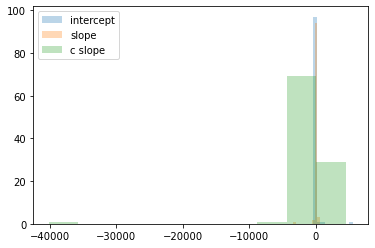

In [20]:
#MC simulation for 100 replications
mcSim = MC_Simulator(100)
mcSim.summarize_mc_simulation(1,2,0.2,10,0.1)
mcSim.plot_parameter_estimates(1,2,0.2,10,0.1,.3)

Mean intercept intercept=23.065 

Mean intercept slope=-2.337 

Mean intercept slope c=-165.290 



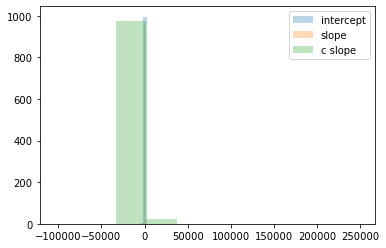

In [21]:
#MC simulation for 1000 replications
mcSim = MC_Simulator(1000)
mcSim.summarize_mc_simulation(1,2,0.2,10,0.1)
mcSim.plot_parameter_estimates(1,2,0.2,10,0.1,.3)

In [22]:
#Calculate bias, rmse, size of treatment effect estimate
N=[100,1000]
a=1
b=2
c=0.2
n=10
for N in [100,1000]:
    slope_estimates = []
    sum_bias= 0
    for mc_replication in range(N):
        u = np.random.uniform(0,1,n)
        e = np.random.normal(0,10,n)
        #X is correlated with u, assume correlation of 0.2
        X=0.2*u
        G = np.random.uniform(0,1,n)
        Y = a+b*X+c*G+e
        Z=np.random.uniform(0,1,n)
        G=sm.add_constant(G)
        mod = IV2SLS(dependent=Y, exog=G, endog=X, instruments=Z)
        res = mod.fit()
        slope_estimates = slope_estimates + [res.params[1]]
        bias = b - res.params[1]
        sum_bias += bias
    rmse = np.sqrt(np.mean(sum_bias**2))
    size = res.params[1]
    print(f'N={N}: bias={bias}, RMSE={rmse}, Size of Treatment Effect={size}')

N=100: bias=11.623040913277336, RMSE=1933.3450488549645, Size of Treatment Effect=-9.623040913277336
N=1000: bias=24.11259411181709, RMSE=15856.906224587581, Size of Treatment Effect=-22.11259411181709


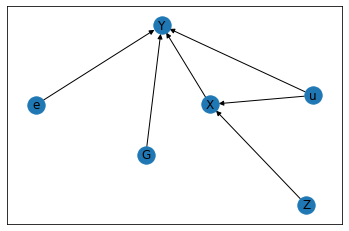

In [23]:
#Create a DAG
import networkx as nx
DAG=nx.DiGraph()
DAG.add_edges_from([("Z","X"),("X","Y"),("G","Y"),("e","Y"),("u","Y"),("u","X")])
plt.tight_layout()
nx.draw_networkx(DAG, arrows=True)

In [1]:
#Real life example: Let Y be earnings and X be compulsory years of schooling. G is gender. Assume gender only affects Y.
#The confounder u in this situation could be ability, ability influences both Y and X. 
#For example, higher levels of ability may lead to higher education and wages.
#Let Z be the instrumental variable. In this case, Z could be quarter of birth. We assume quarter of birth:
#1. Has a causal effect on years of school (X). Due to schooling laws in the US, you enroll in school based on qob. 
#2. Has no direct effect on wage (Y), it only affects Y through X.
#3. Has no confounding effect on Y.


# Question 3

# Part a

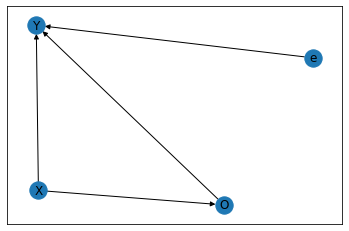

In [24]:
#Create a DAG
import networkx as nx
DAG=nx.DiGraph()
DAG.add_edges_from([("X","Y"), ("e","Y"), ("X","O"),("O","Y")])
plt.tight_layout()
nx.draw_networkx(DAG, arrows=True)

In [25]:
#Real life example:
#The treatment (X) is "email", indicating whether or not an email is sent to potential customers.
#The variable in the path of the treatment is "opened" (O), indicating whether or not the email is opened. 
#"Payments" (Y) is the outcome of whether or not the customer pays. It is caused by both "email" and "opened".
#Opened is caused by the "email" treatment. Opening the email causes payments. Therefore it is a form of selection bias.

In [59]:
#Control for the variable in between the path from cause to effect. 
#Utilize statsmodels mediation package

In [26]:
import statsmodels.api as sm
from statsmodels.stats.mediation import Mediation

In [27]:
#Run 100 and 1000 simulations
N=[100,1000]
a= 1
b= 2
c= 1
d= 3
f= 2
n= 10
a_estimates=[]
b_estimates=[]
c_estimates=[]
d_estimates=[]
f_estimates=[]

for i in N:    
    for j in range(i):
        #Randomly draw X from a uniform distribution and e from a normal distribution
        X = np.random.uniform(0,1,n)
        e = np.random.normal(0,10,n)
        #Randomly draw O from a uniform distribution
        O = np.random.uniform(0,1,n)

        #Two formulas: 
        #Formula for "opened", showing causal effect of email (X) on opened (O) 
        O=c+d*X+e
        #Formula for "payment", including causal effects of email(X) and opened (O)
        Y = a+b*X+f*O+e

        #Prepare parameters for models
        xi=np.array([X,O])
        xi=np.transpose(xi,(1,0))
        Y=np.array([Y])
        Y=np.transpose(Y,(1,0))
        O=np.array([O])
        O=np.transpose(O,(1,0))
        X=np.array([X])
        X=np.transpose(X,(1,0))

        #Model for opened path (mediator model)
        mediator_model = sm.OLS(O,sm.add_constant(X))
        res1=mediator_model.fit()
        c_hat,d_hat=res1.params
        c_estimates= c_estimates+[c_hat]
        d_estimates= d_estimates+[d_hat]

        #Model for payment outcome
        outcome_model = sm.OLS(Y,sm.add_constant(xi))
        res2=outcome_model.fit()
        a_hat,b_hat,f_hat=res2.params
        a_estimates= a_estimates+[a_hat]
        b_estimates= b_estimates+[b_hat]
        f_estimates= f_estimates+[f_hat]    
        
#Overall model output
med=Mediation(outcome_model,mediator_model,(1,1),2).fit()      
med.summary()

,Estimate,Lower CI bound,Upper CI bound,P-value
ACME (control),13.773417,-23.858787,53.929553,0.468
ACME (treated),13.773417,-23.858787,53.929553,0.468
ADE (control),-1.000000,-1.000000,-1.000000,0.000
ADE (treated),-1.000000,-1.000000,-1.000000,0.000
Total effect,12.773417,-24.858787,52.929553,0.494
Prop. mediated (control),1.039213,0.453183,1.745838,0.026
Prop. mediated (treated),1.039213,0.453183,1.745838,0.026
ACME (average),13.773417,-23.858787,53.929553,0.468
ADE (average),-1.000000,-1.000000,-1.000000,0.000
Prop. mediated (average),1.039213,0.453183,1.745838,0.026


In [ ]:
#ADE: average direct effect (direct effect of X on Y accounting for indirect effect of "opened")
#Total effect: total effect of X on Y without "opened" O
#ACME: average causal mediation effects (ie difference in coefficient on X if we excluded "opened"  
#from the regression vs if we include "opened" in outcome regression : ACME= Total effect- ADE)

In [28]:
#Calculate bias, rmse, size of treatment effect estimate
N=[100,1000]
a= 1
b= 2
c= 1
d= 3
f= 2
n= 10
for N in [100,1000]:
    slope_estimates = []
    sum_bias= 0
    for i in range(N):
        X = np.random.uniform(0,1,n)
        e = np.random.normal(0,10,n)
        O = np.random.uniform(0,1,n)
        O=c+d*X+e
        Y=a+b*X+f*O+e
        xi=np.array([X,O])
        xi=np.transpose(xi,(1,0))
        Y=np.array([Y])
        Y=np.transpose(Y,(1,0))
        O=np.array([O])
        O=np.transpose(O,(1,0))
        X=np.array([X])
        X=np.transpose(X,(1,0))
        mediator_model = sm.OLS(O,sm.add_constant(X))
        res1=mediator_model.fit()
        outcome_model = sm.OLS(Y,sm.add_constant(xi))
        res2=outcome_model.fit()
        slope_estimates = slope_estimates + [res2.params[1]]
        bias = b - res.params[1]
        sum_bias += bias
        
    rmse = np.sqrt(np.mean(sum_bias**2))
    size = res.params[1]
    print(f'N={N}: bias={bias}, RMSE={rmse}, Size of Treatment Effect={size}')

N=100: bias=24.11259411181709, RMSE=2411.259411181709, Size of Treatment Effect=-22.11259411181709
N=1000: bias=24.11259411181709, RMSE=24112.594111816506, Size of Treatment Effect=-22.11259411181709


# Part b

In [ ]:
#Do not control for the variable in between the path from cause to effect. 
#In this case, this means don't account for "opened" between "email" and "payment".

In [29]:
class MC_Simulator():
    
    #Initialize
    def __init__(self,n_rep):
        self.n_rep = n_rep
        #n_rep= number of MC (monte carlo) replications 
    
    #Data generating process
    def simulate_data(self, a, b,c,d,f,n,sigma):
        #Let a= intercept, b=slope, n=sample size, sigma=error variance
        #Randomly draw X from a uniform distribution and e from a normal distribution
        X = np.random.uniform(0,1,n)
        e = np.random.normal(0,10,n)
        #O=opened, in path from X to Y
        O=np.random.uniform(0,1,n)
        O=c+d*X+e
        Y=a+b*X+f*O+e
        xi=np.array([X,O])
        xi=np.transpose(xi,(1,0))
        Y=np.array([Y])
        Y=np.transpose(Y,(1,0))
        return (Y,xi)
    
    #Define the OLS model and get parameters
    def estimate_ols_params(self,Y,xi):
        mod = sm.OLS(Y,sm.add_constant(xi))
        res = mod.fit()
        return res.params
    
    #Pass generated data through the OLS model above to get estimates for a and b
    def run_mc_simulation(self,a,b,c,d,f,n,sigma):
        a_estimates = []
        b_estimates = []
        f_estimates = []
        for rep in range(self.n_rep):
            Y,xi = self.simulate_data(a,b,c,d,f,n,sigma)
            #store estimates in a list, append with every iteration
            a_hat,b_hat,f_hat = self.estimate_ols_params(Y,xi)
            a_estimates = a_estimates + [a_hat]
            b_estimates = b_estimates + [b_hat]
            f_estimates = f_estimates + [f_hat]
    
        return a_estimates, b_estimates,f_estimates
    
    #Summarize a, b, f estimates with mean
    def summarize_mc_simulation(self,a,b,c,d,f,n,sigma):
        a_estimates, b_estimates,f_estimates = self.run_mc_simulation(a,b,c,d,f,n,sigma)
        print(f'Mean intercept a={np.mean(a_estimates):.3f} \n')
        print(f'Mean intercept b={np.mean(b_estimates):.3f} \n')
        print(f'Mean intercept f={np.mean(f_estimates):.3f} \n')
    
    #Plot parameter estimates
    def plot_parameter_estimates(self,a,b,c,d,f,n,sigma,alpha):
        a_estimates, b_estimates,f_estimates = self.run_mc_simulation(a,b,c,d,f,n,sigma)
        fig = plt.figure()
        plt.hist(a_estimates, label = 'intercept', alpha = alpha)
        plt.hist(b_estimates, label = 'slope:email', alpha = alpha)
        plt.hist(f_estimates, label = 'slope:opened',alpha=alpha)
        plt.legend()

In [31]:
#MC simulation for 100 replications
mcSim = MC_Simulator(100)
mcSim.summarize_mc_simulation(1,2,1,3,2,10,0.1)

Mean intercept a=0.000 

Mean intercept b=-1.000 

Mean intercept f=3.000 



In [33]:
#MC simulation for 1000 replications
mcSim = MC_Simulator(1000)
mcSim.summarize_mc_simulation(1,2,1,3,2,10,0.1)

Mean intercept a=0.000 

Mean intercept b=-1.000 

Mean intercept f=3.000 



In [34]:
#Calculate bias, rmse, size of treatment effect estimate
N=[100,1000]
a=1
b=2
n=10
for N in [100,1000]:
    slope_estimates = []
    sum_bias= 0
    for mc_replication in range(N):
        X = np.random.uniform(0,1,n)
        e = np.random.normal(0,10,n)
        O=np.random.uniform(0,1,n)
        O=c+d*X+e
        Y=a+b*X+f*O+e
        xi=np.array([X,O])
        xi=np.transpose(xi,(1,0))
        Y=np.array([Y])
        Y=np.transpose(Y,(1,0))
        mod = sm.OLS(Y,sm.add_constant(xi))
        res = mod.fit()
        slope_estimates = slope_estimates + [res.params[1]]
        bias = b - res.params[1]
        sum_bias += bias
    rmse = np.sqrt(np.mean(sum_bias**2))
    size = res.params[1]
    print(f'N={N}: bias={bias}, RMSE={rmse}, Size of Treatment Effect={size}')

N=100: bias=3.0, RMSE=300.0000000000002, Size of Treatment Effect=-1.0
N=1000: bias=3.0, RMSE=2999.9999999999995, Size of Treatment Effect=-1.0
